In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2021-ai-w7-p1/mnist_test.csv
/kaggle/input/2021-ai-w7-p1/mnist_train.csv
/kaggle/input/2021-ai-w7-p1/submission.csv


# 데이터 로드

In [2]:
x_train = pd.read_csv("/kaggle/input/2021-ai-w7-p1/mnist_train.csv",index_col=0)
x_test = pd.read_csv("/kaggle/input/2021-ai-w7-p1/mnist_test.csv",index_col=0)

In [3]:
x_train.shape

(60000, 785)

In [4]:
x_train = np.array(x_train)
y_train = x_train[:,-1]
x_train = x_train[:,:-1]
x_test = np.array(x_test)

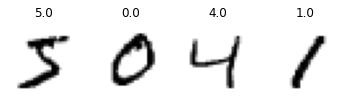

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4)

for i, ax in enumerate(axes.flat):
    ax.imshow(1 - x_train[i].reshape((28, 28)), cmap="gray")
    ax.set(title=f"{y_train[i]}")
    ax.set_axis_off()

In [6]:
import torch
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

x_train = torch.tensor(x_train, dtype=torch.float) / 255 #정규화
x_test = torch.tensor(x_test, dtype=torch.float) / 255 #정규화
y_train = torch.tensor([int(x) for x in y_train])

In [7]:
# 학습 파라미터 설정
learning_rate = 0.001
training_epochs = 15
batch_size = 100
drop_prob = 0.4

# 모델 빌드

In [8]:
linear1 = torch.nn.Linear(784,512,bias=True)
linear2 = torch.nn.Linear(512,512,bias=True)
linear3 = torch.nn.Linear(512,512,bias=True)
linear4 = torch.nn.Linear(512,512,bias=True)
linear5 = torch.nn.Linear(512,10,bias=True)
relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p=drop_prob)

In [9]:
# Random Init => Xavier Init
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

Parameter containing:
tensor([[-0.0565,  0.0423, -0.0155,  ...,  0.1012,  0.0459, -0.0191],
        [ 0.0772,  0.0452, -0.0638,  ...,  0.0476, -0.0638,  0.0528],
        [ 0.0311, -0.1023, -0.0701,  ...,  0.0412, -0.1004,  0.0738],
        ...,
        [ 0.0334,  0.0187, -0.1021,  ...,  0.0280, -0.0583, -0.1018],
        [-0.0506, -0.0939, -0.0467,  ..., -0.0554, -0.0325,  0.0640],
        [-0.0183, -0.0123,  0.1025,  ..., -0.0214,  0.0220, -0.0741]],
       requires_grad=True)

In [10]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [11]:
# ======================================
# relu는 맨 마지막 레이어에서 빼는 것이 좋다.
# ======================================
model = torch.nn.Sequential(linear1,relu,dropout,
                            linear2,relu,dropout,
                            linear3,relu,dropout,
                            linear4,relu,dropout,
                            linear5).to(device)

In [12]:
# 손실함수와 최적화 함수
loss = torch.nn.CrossEntropyLoss().to(device) # softmax 내부적으로 계산
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [13]:
total_batch = len(train_loader)

model.train() # 주의사항 drop_out = True

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in train_loader:

        X = X.to(device)
        Y = Y.to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()
        # Forward 계산
        hypothesis = model(X)
        # Error 계산
        cost = loss(hypothesis, Y)
        # Backparopagation
        cost.backward()
        # 가중치 갱신
        optimizer.step()

        # 평균 Error 계산
        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.386804968
Epoch: 0002 cost = 0.183438346
Epoch: 0003 cost = 0.139510721
Epoch: 0004 cost = 0.124865189
Epoch: 0005 cost = 0.110133938
Epoch: 0006 cost = 0.095616616
Epoch: 0007 cost = 0.093641818
Epoch: 0008 cost = 0.086881146
Epoch: 0009 cost = 0.081558123
Epoch: 0010 cost = 0.077296913
Epoch: 0011 cost = 0.074462757
Epoch: 0012 cost = 0.066425204
Epoch: 0013 cost = 0.068356603
Epoch: 0014 cost = 0.066540107
Epoch: 0015 cost = 0.065938637
Learning finished


In [14]:
with torch.no_grad():
    model.eval()
    
    x_test = x_test.to(device)
    y_test_pred = model(x_test)
    y_test_pred = torch.argmax(y_test_pred,1)

In [15]:
y_test_pred = y_test_pred.cpu().numpy()

In [16]:
submit = pd.read_csv("/kaggle/input/2021-ai-w7-p1/submission.csv")

In [17]:
submit['Label'] = y_test_pred
submit

,id,Label
0,0,7
1,1,2
2,2,1
3,3,0
4,4,4
...,...,...
9995,9995,2
9996,9996,3
9997,9997,4
9998,9998,5


In [18]:
submit.to_csv('./DNN_MNIST_prediction-kiy-drop0.4.csv',index=False)

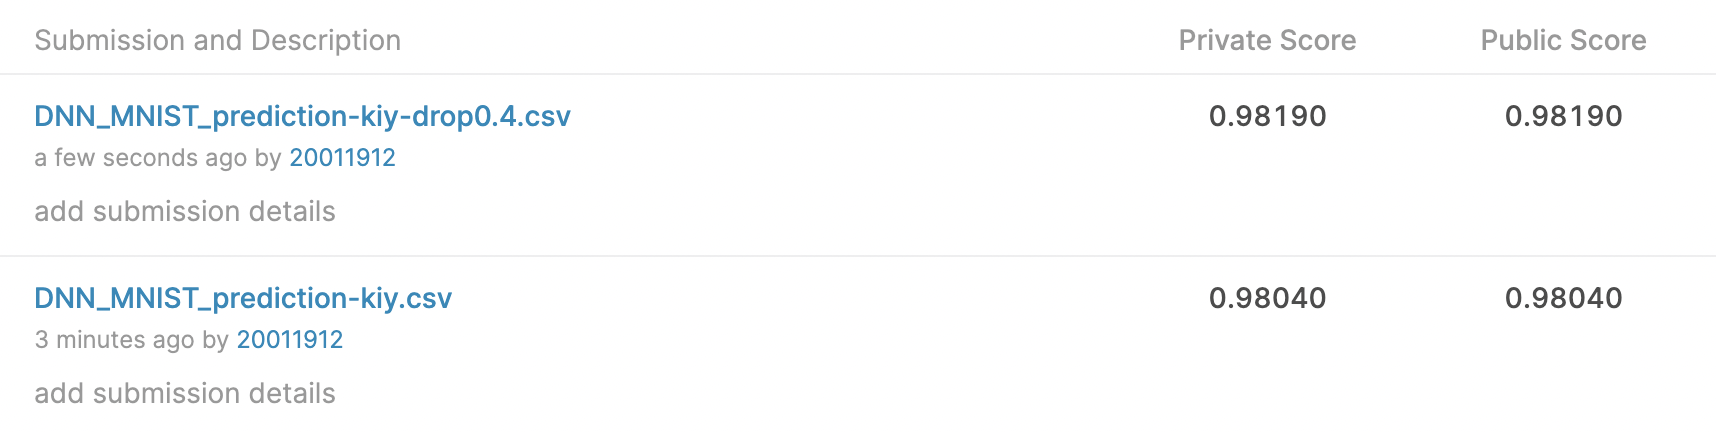